### This code is refer to Peiwen Yang's post in Zhihu

In [ ]:
import os
import shutil

train_filenames = os.listdir('train')
train_cat = filter(lambda x : x[:3]=='cat', train_filenames)
train_dog = filter(lambda x : x[:3]=='dog', train_filenames)

def rmrf_mkdir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)
    
rmrf_mkdir('train2')
os.mkdir('train2/cat')
os.mkdir('train2/dog')
rmrf_mkdir('test2')
os.symlink('../test/','test2/test')

for fileName in train_cat:
    os.symlink('../../train/'+fileName, 'train2/cat/'+fileName)
for fileName in train_dog:
    os.symlink('../../train/'+fileName, 'train2/dog/'+fileName)

In [ ]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
import h5py

In [ ]:
def write_gap(MODEL, image_size, lambda_func=None):
    start_time = time.time()
    print (MODEL.func_name)
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory("train2", image_size, shuffle=False, 
                                              batch_size=16)
    test_generator = gen.flow_from_directory("test2", image_size, shuffle=False, 
                                             batch_size=16, class_mode=None)
    print('check point')
    train = model.predict_generator(train_generator, train_generator.nb_sample)
    test = model.predict_generator(test_generator, test_generator.nb_sample)
    
    with h5py.File("gap_%s.h5"%MODEL.func_name) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_generator.classes)
    elapsed_time = time.time() - start_time
    print('elapsed time {}'.format(elapsed_time))

In [ ]:
write_gap(ResNet50, (224, 224))

In [ ]:
write_gap(InceptionV3, (299, 299), inception_v3.preprocess_input)

In [ ]:
import time
write_gap(Xception, (299, 299), xception.preprocess_input)

In [1]:
import h5py
import numpy as np
from sklearn.utils import shuffle
np.random.seed(2017)

X_train = []
X_test = []

for filename in ["gap_ResNet50.h5", "gap_Xception.h5", "gap_InceptionV3.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, y_train = shuffle(X_train, y_train)

In [2]:
from keras.models import *
from keras.layers import *

np.random.seed(2017)

input_tensor = Input(X_train.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Using TensorFlow backend.


In [3]:
model.fit(X_train, y_train, batch_size=128, nb_epoch=8, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/8
20000/20000 [==============================] - 4s - loss: 0.1067 - acc: 0.9664 - val_loss: 0.0310 - val_acc: 0.9916

In [ ]:
model.save('model.h5')

In [4]:
y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

11936/12500 [===========================>..] - ETA: 0s

In [ ]:
y_pred[0]

Found 12500 images belonging to 1 classes.


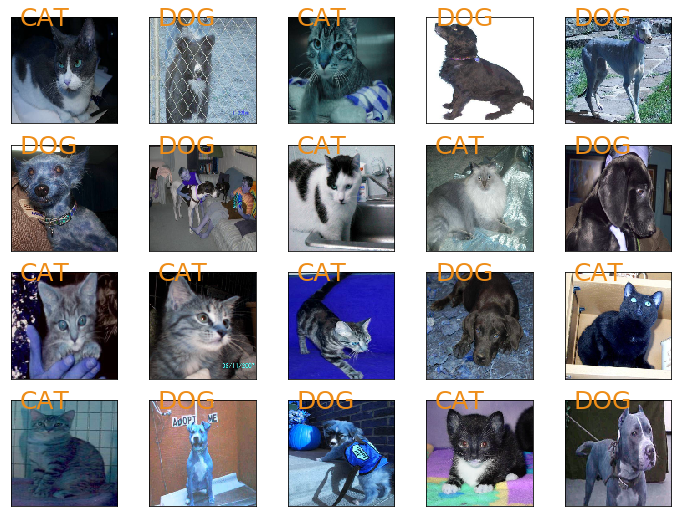

In [21]:
import cv2
import pandas as pd
from keras.preprocessing.image import *
import matplotlib.pyplot as plt

image_size = (224, 224)
gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("test2", image_size, shuffle=False, 
                                         batch_size=16, class_mode=None)
fig=plt.figure(figsize=(12,9))
for i, fname in enumerate(test_generator.filenames[12:32]):
    img = cv2.imread(fname)
    img = cv2.resize(img, (128, 128))
    y = fig.add_subplot(4,5,i+1)
    if y_pred[i+12] > 0.5:
        classType = "DOG"
    else:
        classType = "CAT"
    #plt.figure(figsize=(8,4))
    #plt.imshow(img)
    y.imshow(img)
    #plt.annotate(classType, xy=(2, 1),size= 25,color='#ee8d18', xytext=(10, 10))
    y.annotate(classType, xy=(2, 1),size= 25,color='#ee8d18', xytext=(10, 10))
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [ ]:
import pandas as pd
from keras.preprocessing.image import *

df = pd.read_csv("sample_submission.csv")

image_size = (224, 224)
gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("test2", image_size, shuffle=False, 
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('pred.csv', index=None)
df.head(10)